In [1]:
import zap
import pypsa
from zap.tests import network_examples as examples

In [2]:
pn = examples.load_example_network('texas_7node')
pn

INFO:pypsa.io:Imported network texas_7node.nc has buses, carriers, generators, lines, loads, storage_units


PyPSA Network
Components:
 - Bus: 7
 - Carrier: 17
 - Generator: 176
 - Line: 12
 - Load: 7
 - StorageUnit: 14
Snapshots: 48

In [3]:
net, devices = zap.importers.load_pypsa_network(pn, power_unit=1e3, cost_unit=10.0)

INFO:zap.importers.pypsa:Importing Generator with 136 devices.
INFO:zap.importers.pypsa:Importing Load with 7 devices.
INFO:zap.importers.pypsa:Importing ACLine with 12 devices.
INFO:zap.importers.pypsa:Importing StorageUnit with 14 devices.


In [4]:
results = net.dispatch(devices=devices, time_horizon=48)

/Users/kamrantehranchi/Library/Caches/pypoetry/virtualenvs/zap-qb0btW3r-py3.12/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [5]:
device_index = 0
results.power[0][0].shape

(136, 48)

In [6]:
zap_pypsa = zap.exporters.export_to_pypsa(net, devices, results, snapshots=pn.snapshots)
zap_pypsa

/Users/kamrantehranchi/Local_Documents/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.generators_t[attr][name] = df.loc[name]
/Users/kamrantehranchi/Local_Documents/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.generators_t[attr][name] = df.loc[name]
/Users/kamrantehranchi/Local_Documents/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

PyPSA Network
Components:
 - Bus: 7
 - Generator: 136
 - Line: 12
 - Load: 7
 - StorageUnit: 14
Snapshots: 48

In [7]:
kwargs = {}
kwargs["solver_name"] = "gurobi"
kwargs["solver_options"] = {"method": 2, "crossover": 0, "BarHomogeneous": 1, "BarConvTol": 1.e-5, "OptimalityTol": 1.e-4, "FeasibilityTol": 1.e-3, "ScaleFlag": 1, "Seed": 123, "AggFill": 0, "PreDual": 0, "GURO_PAR_BARDENSETHRESH": 200}
kwargs["solver_options"]["mipgap"] = 0.01    
kwargs["multi_investment_periods"] = True
kwargs['transmission_losses'] = False
kwargs["assign_all_duals"] = True

pn.optimize(**kwargs)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - crossover: 0
 - BarHomogeneous: 1
 - BarConvTol: 1e-05
 - OptimalityTol: 0.0001
 - FeasibilityTol: 0.001
 - ScaleFlag: 1
 - Seed: 123
 - AggFill: 0
 - PreDual: 0
 - GURO_PAR_BARDENSETHRESH: 200
 - mipgap: 0.01


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-01-01


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-01
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 202.02it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-jh5ueg0j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-jh5ueg0j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 26605 rows, 9257 columns, 57135 nonzeros


INFO:gurobipy:obj: 26605 rows, 9257 columns, 57135 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Crossover to value 0


INFO:gurobipy:Set parameter Crossover to value 0


Set parameter BarHomogeneous to value 1


INFO:gurobipy:Set parameter BarHomogeneous to value 1


Set parameter BarConvTol to value 1e-05


INFO:gurobipy:Set parameter BarConvTol to value 1e-05


Set parameter OptimalityTol to value 0.0001


INFO:gurobipy:Set parameter OptimalityTol to value 0.0001


Set parameter FeasibilityTol to value 0.001


INFO:gurobipy:Set parameter FeasibilityTol to value 0.001


Set parameter ScaleFlag to value 1


INFO:gurobipy:Set parameter ScaleFlag to value 1


Set parameter Seed to value 123


INFO:gurobipy:Set parameter Seed to value 123


Set parameter AggFill to value 0


INFO:gurobipy:Set parameter AggFill to value 0


Set parameter PreDual to value 0


INFO:gurobipy:Set parameter PreDual to value 0


Set parameter GURO_PAR_BARDENSETHRESH to value 200


INFO:gurobipy:Set parameter GURO_PAR_BARDENSETHRESH to value 200


Set parameter MIPGap to value 0.01


INFO:gurobipy:Set parameter MIPGap to value 0.01


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


FeasibilityTol  0.001


INFO:gurobipy:FeasibilityTol  0.001


MIPGap  0.01


INFO:gurobipy:MIPGap  0.01


OptimalityTol  0.0001


INFO:gurobipy:OptimalityTol  0.0001


Method  2


INFO:gurobipy:Method  2


ScaleFlag  1


INFO:gurobipy:ScaleFlag  1


BarConvTol  1e-05


INFO:gurobipy:BarConvTol  1e-05


BarHomogeneous  1


INFO:gurobipy:BarHomogeneous  1


Crossover  0


INFO:gurobipy:Crossover  0


AggFill  0


INFO:gurobipy:AggFill  0


PreDual  0


INFO:gurobipy:PreDual  0


Seed  123


INFO:gurobipy:Seed  123


GURO_PAR_BARDENSETHRESH  200


INFO:gurobipy:GURO_PAR_BARDENSETHRESH  200


INFO:gurobipy:


Optimize a model with 26605 rows, 9257 columns and 57135 nonzeros


INFO:gurobipy:Optimize a model with 26605 rows, 9257 columns and 57135 nonzeros


Model fingerprint: 0x768bd279


INFO:gurobipy:Model fingerprint: 0x768bd279


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-04, 3e+02]


INFO:gurobipy:  Matrix range     [4e-04, 3e+02]


  Objective range  [1e+00, 3e+05]


INFO:gurobipy:  Objective range  [1e+00, 3e+05]


  Bounds range     [2e+09, 2e+09]


INFO:gurobipy:  Bounds range     [2e+09, 2e+09]


  RHS range        [3e-03, 5e+05]


INFO:gurobipy:  RHS range        [3e-03, 5e+05]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 13065 rows and 1146 columns


INFO:gurobipy:Presolve removed 13065 rows and 1146 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 13540 rows, 8111 columns, 42375 nonzeros


INFO:gurobipy:Presolved: 13540 rows, 8111 columns, 42375 nonzeros


Ordering time: 0.10s


INFO:gurobipy:Ordering time: 0.10s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 8.026e+05


INFO:gurobipy: AA' NZ     : 8.026e+05


 Factor NZ  : 1.352e+06 (roughly 20 MB of memory)


INFO:gurobipy: Factor NZ  : 1.352e+06 (roughly 20 MB of memory)


 Factor Ops : 1.574e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.574e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.36078679e+11 -2.47349074e+12  6.56e+05 4.65e+03  5.27e+09     0s


INFO:gurobipy:   0   3.36078679e+11 -2.47349074e+12  6.56e+05 4.65e+03  5.27e+09     0s


   1   3.68605547e+11 -2.16006808e+12  3.54e+05 7.15e+04  2.05e+09     0s


INFO:gurobipy:   1   3.68605547e+11 -2.16006808e+12  3.54e+05 7.15e+04  2.05e+09     0s


   2   3.76272472e+11 -2.03227739e+12  1.44e+05 3.73e+04  9.63e+08     0s


INFO:gurobipy:   2   3.76272472e+11 -2.03227739e+12  1.44e+05 3.73e+04  9.63e+08     0s


   3   3.68931016e+11 -1.54452990e+12  4.19e+04 1.29e+04  3.45e+08     1s


INFO:gurobipy:   3   3.68931016e+11 -1.54452990e+12  4.19e+04 1.29e+04  3.45e+08     1s


   4   1.10625328e+11 -3.20908858e+11  3.43e+03 3.06e+03  3.42e+07     1s


INFO:gurobipy:   4   1.10625328e+11 -3.20908858e+11  3.43e+03 3.06e+03  3.42e+07     1s


   5   4.46226121e+10 -1.12588513e+11  5.38e+02 1.17e+03  9.77e+06     1s


INFO:gurobipy:   5   4.46226121e+10 -1.12588513e+11  5.38e+02 1.17e+03  9.77e+06     1s


   6   2.19349466e+10 -5.91877765e+10  1.58e+02 6.65e+02  4.52e+06     1s


INFO:gurobipy:   6   2.19349466e+10 -5.91877765e+10  1.58e+02 6.65e+02  4.52e+06     1s


   7   1.08966979e+10 -3.46206213e+10  5.06e+01 3.99e+02  2.37e+06     1s


INFO:gurobipy:   7   1.08966979e+10 -3.46206213e+10  5.06e+01 3.99e+02  2.37e+06     1s


   8   7.35998486e+09 -1.13534293e+10  2.56e+01 1.16e+02  9.45e+05     1s


INFO:gurobipy:   8   7.35998486e+09 -1.13534293e+10  2.56e+01 1.16e+02  9.45e+05     1s


   9   4.84032265e+09 -3.21234448e+09  1.47e+01 5.40e+01  3.91e+05     1s


INFO:gurobipy:   9   4.84032265e+09 -3.21234448e+09  1.47e+01 5.40e+01  3.91e+05     1s


  10   2.66461283e+09 -3.31295305e+08  6.89e+00 1.61e+01  1.43e+05     1s


INFO:gurobipy:  10   2.66461283e+09 -3.31295305e+08  6.89e+00 1.61e+01  1.43e+05     1s


  11   1.97193406e+09  5.17909304e+08  3.54e+00 7.99e+00  6.89e+04     1s


INFO:gurobipy:  11   1.97193406e+09  5.17909304e+08  3.54e+00 7.99e+00  6.89e+04     1s


  12   1.76582685e+09  9.76973924e+08  2.31e+00 2.35e+00  3.66e+04     1s


INFO:gurobipy:  12   1.76582685e+09  9.76973924e+08  2.31e+00 2.35e+00  3.66e+04     1s


  13   1.34399226e+09  1.08104725e+09  6.01e-01 1.04e+00  1.24e+04     1s


INFO:gurobipy:  13   1.34399226e+09  1.08104725e+09  6.01e-01 1.04e+00  1.24e+04     1s


  14   1.31918411e+09  1.12624011e+09  5.18e-01 5.14e-01  8.92e+03     1s


INFO:gurobipy:  14   1.31918411e+09  1.12624011e+09  5.18e-01 5.14e-01  8.92e+03     1s


  15   1.29481344e+09  1.13691344e+09  4.36e-01 3.40e-01  7.28e+03     1s


INFO:gurobipy:  15   1.29481344e+09  1.13691344e+09  4.36e-01 3.40e-01  7.28e+03     1s


  16   1.26148619e+09  1.15339487e+09  3.08e-01 2.42e-01  4.96e+03     1s


INFO:gurobipy:  16   1.26148619e+09  1.15339487e+09  3.08e-01 2.42e-01  4.96e+03     1s


  17   1.20708283e+09  1.16289907e+09  1.19e-01 8.77e-02  2.04e+03     1s


INFO:gurobipy:  17   1.20708283e+09  1.16289907e+09  1.19e-01 8.77e-02  2.04e+03     1s


  18   1.18559987e+09  1.16753208e+09  4.81e-02 3.52e-02  8.32e+02     1s


INFO:gurobipy:  18   1.18559987e+09  1.16753208e+09  4.81e-02 3.52e-02  8.32e+02     1s


  19   1.17420933e+09  1.16964941e+09  1.06e-02 1.43e-02  2.12e+02     1s


INFO:gurobipy:  19   1.17420933e+09  1.16964941e+09  1.06e-02 1.43e-02  2.12e+02     1s


  20   1.17256726e+09  1.17033176e+09  5.45e-03 4.12e-03  1.03e+02     1s


INFO:gurobipy:  20   1.17256726e+09  1.17033176e+09  5.45e-03 4.12e-03  1.03e+02     1s


  21   1.17193846e+09  1.17061448e+09  3.50e-03 2.53e-03  6.06e+01     1s


INFO:gurobipy:  21   1.17193846e+09  1.17061448e+09  3.50e-03 2.53e-03  6.06e+01     1s


  22   1.17115793e+09  1.17076855e+09  1.05e-03 5.45e-04  1.77e+01     1s


INFO:gurobipy:  22   1.17115793e+09  1.17076855e+09  1.05e-03 5.45e-04  1.77e+01     1s


  23   1.17084410e+09  1.17080535e+09  7.08e-05 1.17e-04  1.83e+00     1s


INFO:gurobipy:  23   1.17084410e+09  1.17080535e+09  7.08e-05 1.17e-04  1.83e+00     1s


  24   1.17082699e+09  1.17082158e+09  5.69e-05 7.77e-06  2.46e-01     1s


INFO:gurobipy:  24   1.17082699e+09  1.17082158e+09  5.69e-05 7.77e-06  2.46e-01     1s


  25   1.17082239e+09  1.17082229e+09  1.02e-03 8.98e-05  6.08e-03     1s


INFO:gurobipy:  25   1.17082239e+09  1.17082229e+09  1.02e-03 8.98e-05  6.08e-03     1s


  26   1.17082232e+09  1.17082232e+09  9.35e-06 1.66e-06  5.38e-05     1s


INFO:gurobipy:  26   1.17082232e+09  1.17082232e+09  9.35e-06 1.66e-06  5.38e-05     1s


  27   1.17082232e+09  1.17082232e+09  1.69e-08 1.57e-07  6.83e-09     1s


INFO:gurobipy:  27   1.17082232e+09  1.17082232e+09  1.69e-08 1.57e-07  6.83e-09     1s


INFO:gurobipy:


Barrier solved model in 27 iterations and 1.30 seconds (0.62 work units)


INFO:gurobipy:Barrier solved model in 27 iterations and 1.30 seconds (0.62 work units)


Optimal objective 1.17082232e+09


INFO:gurobipy:Optimal objective 1.17082232e+09


INFO:gurobipy:
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9257 primals, 26605 duals
Objective: 1.17e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='period,timestep'>

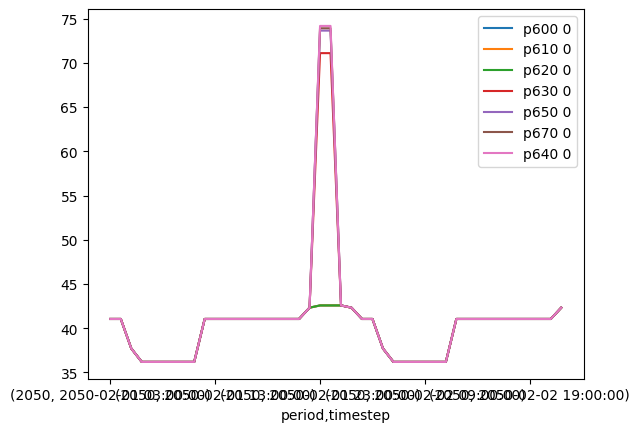

In [13]:
pn.buses_t.marginal_price.iloc[3:-1].plot()

<Axes: xlabel='period,timestep'>

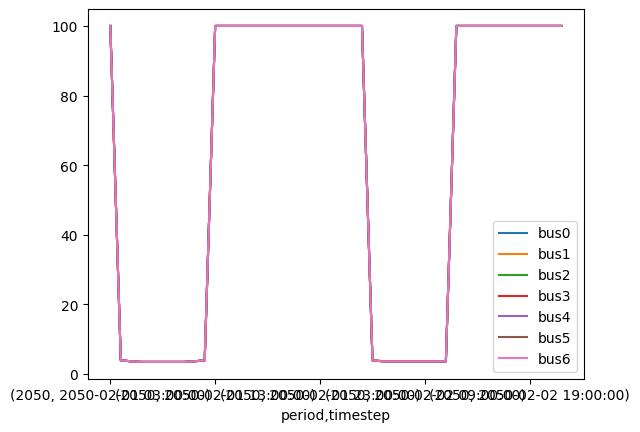

In [14]:
zap_pypsa.buses_t.marginal_price.iloc[3:-1].plot()